In [1]:
import datetime
import matplotlib.pyplot as plt
import pyaurorax
import cartopy.crs
import pprint

aurorax = pyaurorax.PyAuroraX()
at = aurorax.tools

# Create REGO mosaic in calibrated Rayleighs

Combining the mosaic and calibration functionality, we can generate a mosaic of REGO data calibrated to Rayleighs.

Let's have a look at an example.

### Step 1: Download Raw Image Data

In [2]:
# download a minute of REGO data from several sites
dataset_name = "REGO_RAW"
dt = datetime.datetime(2018, 1, 14, 4, 48)
site_uid_list = ["resu", "talo", "gill", "fsmi", "fsim"]
data_list = []
for site_uid in site_uid_list:
    r = aurorax.data.ucalgary.download(dataset_name, dt, dt, site_uid=site_uid)
    data = aurorax.data.ucalgary.read(r.dataset, r.filenames)
    data_list.append(data)

### Step 2: Download and read skymap data

In [3]:
# download and read the skymaps
skymaps = []
for site_uid in site_uid_list:
    download_obj = aurorax.data.ucalgary.download_best_skymap("REGO_SKYMAP_IDLSAV", site_uid, dt)
    skymap_data = aurorax.data.ucalgary.read(download_obj.dataset, download_obj.filenames[0])
    skymaps.append(skymap_data.data[0])

pprint.pprint(skymaps)
print()
print(f"Have {len(skymaps)} skymaps")

[Skymap(project_uid=rego, site_uid=resu, imager_uid=rego-655, site_map_latitude=74.733002, site_map_longitude=265.100006, ...),
 Skymap(project_uid=rego, site_uid=talo, imager_uid=rego-657, site_map_latitude=69.540924, site_map_longitude=266.443268, ...),
 Skymap(project_uid=rego, site_uid=gill, imager_uid=rego-652, site_map_latitude=56.380001, site_map_longitude=265.359985, ...),
 Skymap(project_uid=rego, site_uid=fsmi, imager_uid=rego-656, site_map_latitude=60.026112, site_map_longitude=248.067062, ...),
 Skymap(project_uid=rego, site_uid=fsim, imager_uid=rego-654, site_map_latitude=61.759998, site_map_longitude=238.779999, ...)]

Have 5 skymaps


### Step 3: Download and read calibration files

In [4]:
# Get list of all device UIDs up to date of interest for each site
device_uid_list = []
for data in data_list:
    print(data.metadata[0]["Imager unique ID"])
    device_uid_list.append(data.metadata[0]["Imager unique ID"][-3:])

print()
print(device_uid_list)

rego-655
rego-657
rego-652
rego-656
rego-654

['655', '657', '652', '656', '654']


In [5]:
# download and read flatfield data
flatfields = []
for device_uid in device_uid_list:
    r = aurorax.data.ucalgary.download_best_flatfield_calibration("REGO_CALIBRATION_FLATFIELD_IDLSAV", device_uid, dt)
    data = aurorax.data.ucalgary.read(r.dataset, r.filenames[0])
    flatfields.append(data.data[0])
print(f"Have {len(flatfields)} flatfield correction data")

# download and read flatfield data
rayleighs = []
for device_uid in device_uid_list:
    r = aurorax.data.ucalgary.download_best_rayleighs_calibration("REGO_CALIBRATION_RAYLEIGHS_IDLSAV", device_uid, dt)
    data = aurorax.data.ucalgary.read(r.dataset, r.filenames[0])
    rayleighs.append(data.data[0])
print(f"Have {len(rayleighs)} rayleigh calibration data")

Have 5 flatfield correction data
Have 5 rayleigh calibration data


### Step 4: Calibrate the image data

In [6]:
# apply corrections and calibrations and store in list for mosaic
for i, image_data in enumerate(data_list):
    # calibrate data
    calibrated_image_data = at.calibration.rego(image_data.data, cal_flatfield=flatfields[i], cal_rayleighs=rayleighs[i])

    # replace the data in image_data with the calibrated version
    data_list[i].calibrated_data = calibrated_image_data

### Step 5: Inspect calibrated data

An important step here is to have a look at the calibrated data we have to make sure we're looking at what we expect to. Let's plot a frame of calibrated data from each camera.

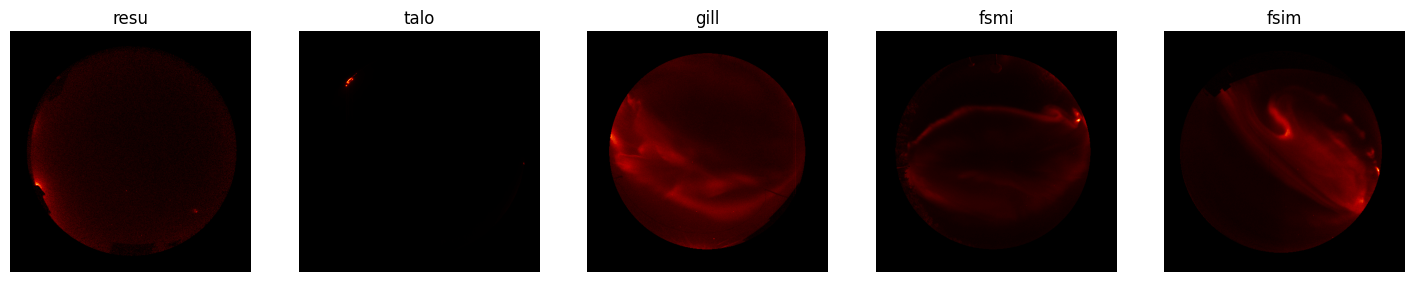

In [7]:
# plot each site, and label with the min and max of the data, so we can get a good idea of how we should scale.
plt.figure(figsize=(18, 5))
for i, image_data in enumerate(data_list):
    plt.subplot(1, len(site_uid_list), i + 1)
    plt.title(site_uid_list[i])
    plt.imshow(image_data.calibrated_data[:, :, 0], cmap="gist_heat", origin="lower")
    plt.axis("off")

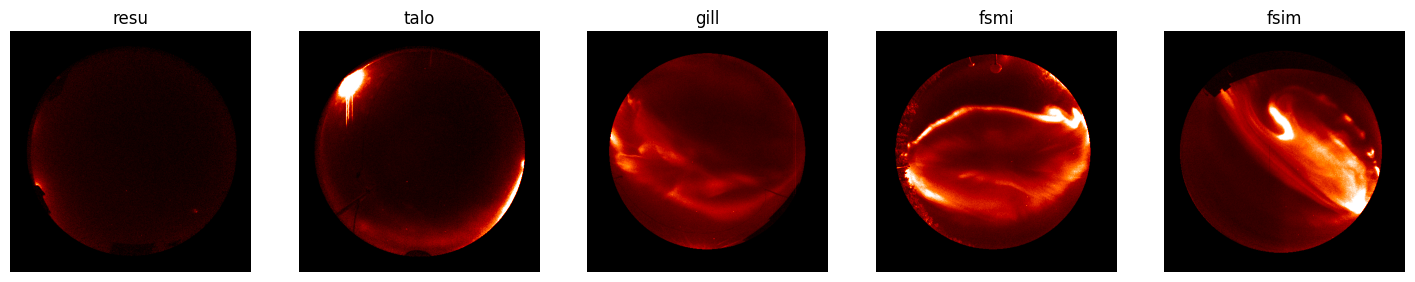

In [8]:
# Since we are working with absolute intensity data, ALL SITES MUST BE SCALED THE SAME
#
# let's mess around with the scaling
scale_bounds = [0, 5000]

# Let's plot each site, and label with the min and max of the data, so we can get a good idea of how we should scale.
plt.figure(figsize=(18, 5))
for i, image_data in enumerate(data_list):
    plt.subplot(1, len(site_uid_list), i + 1)
    plt.title(site_uid_list[i])
    cal_data = at.scale_intensity(image_data.calibrated_data, min=scale_bounds[0], max=scale_bounds[1], top=255)
    plt.imshow(cal_data[:, :, 0], cmap="gist_heat", origin="lower")
    plt.axis("off")

### Step 6: Generate the mosaic

Now that we have the data calibrated and scaled how we'd like, it's time to finally generate the mosaic.

In [9]:
# prepare skymaps
prepped_skymap = at.mosaic.prep_skymaps(skymaps, 230, n_parallel=5)  # we'll use 230km for these redline emissions
print(prepped_skymap)

Preparing skymaps:   0%|          | 0/5 [00:00<?, ?skymap/s]

MosaicSkymap(polyfill_lat=array(dims=(5, 262144), dtype=float64), polyfill_lon=array(dims=(5, 262144), dtype=float64), elevation=array(dims=(262144,), dtype=float32), site_uid_list=['resu', 'talo', 'gill', 'fsmi', 'fsim'])


In [10]:
# prepare the image data
prepped_images = at.mosaic.prep_images(data_list, data_attribute="calibrated_data")
print(prepped_images)

MosaicData(images=Dict[5 sites of array(dims=(512, 512))], timestamps=[20 timestamps], site_uid_list=['resu', 'talo', 'gill', 'fsmi', 'fsim'])


In [11]:
# define the intensity scales for each site... all the same, as we're working in Rayleighs
scale_bounds = (0, 5000)
scale = {
    "resu": scale_bounds,
    "talo": scale_bounds,
    "gill": scale_bounds,
    "fsmi": scale_bounds,
    "fsim": scale_bounds,
}

# set timestamp to actually create mosaic frame for
mosaic_dt = datetime.datetime(2018, 1, 14, 4, 48, 15)

# create projection
center_lat = -100.0
center_lon = 55.0
projection_obj = cartopy.crs.NearsidePerspective(central_longitude=center_lat, central_latitude=center_lon)

# create mosaic
mosaic = at.mosaic.create(prepped_images,
                          prepped_skymap,
                          mosaic_dt,
                          projection_obj,
                          image_intensity_scales=scale,
                          colormap="gist_heat",
                          min_elevation=10)
print(mosaic)

Mosaic(polygon_data=PolyCollection(...), cartopy_projection=Projection(+proj=nsper +a=6378137.0 +lon_0=-100.0 +lat_0=55.0 +h=35785831 +x_0=0 +y_0=0 +units=m +no_defs +type=crs))


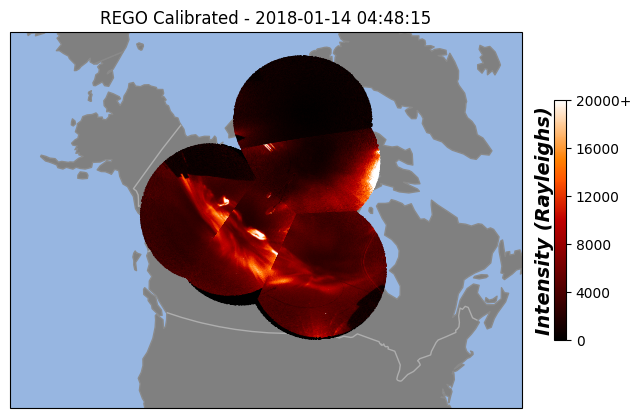

In [12]:
# plot mosaic
map_extent = [-145, -65, 33, 85]
mosaic.plot(
    map_extent,
    rayleighs=True,
    cbar_colormap="gist_heat",
    title="REGO Calibrated - %s" % (mosaic_dt.strftime("%Y-%m-%d %H:%M:%S")),
)